In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex Matching Engine with PaLM

## Overview

Most Enterprise customers have large corpus of documents.
Though LLMs and PaLM has pre-built information about its trained data, asking LLMs like Bard and Palm for open questions are fun, but does not help the Enterprise Users. An enterprise user is more interested in the asking questions about the documents and information than open ended questions on the internet.

The only way to interact with LLMs is via prompts. To build a useful prompt to a users context on LLMs, the prompt needs to be made up of two parts
 - The Users Question
 - The relevant texts from the Enterprise Knowledge Corpus relevant to the above Question.

 A well formatted prompt when submitted to a LLM like PaLM can return relevant answers back. To build list of extracted text, is a hard problem and that is where we are going to spend most of the work in the series of notebooks.

To get a list of documents from the enterprise we need to find documents that are similar or relevant to the user's question. To solve this at scale we need to use a Vector Store/Matching Engine. Vertex Matching Engine gives a fast and scalable way to query document matches.

Matching Engine stores Vector Representations. This can be of Text, Images, Audio, it does not matter. The newly release PaLM Embedding API provides the service to convert Text into a 768 size vector. We could use other models, why not use something that is robust and easy :).

Matching Engine only stores vectors. When we do set of matches, we need to retrieve the document snippets back. For this we will use Bigtable for its performance as an enterprise grade Columnar Storage.

We will also use BigTable as place to log request and responses from the User. This can help in performing prompt analytics for the enterprise users.

Lets start putting it all together.

## Notebooks
There are 4 Notebooks
- Wikipedia Data Processing (This one)
- Wikipedia Embedding Generator
- WikiPedia Matching Engine
- FinalWikiPedia MatchingEngine BigTableQA

The first one we scrape the Wikipedia site and extract text, chunk it and store it. Think of this step as dataprocessing in an Enterprise. If you alreadry have a corpus of wikipedia articles, how would you chunk ingest them. The reason we chunk it, so that we can extract small relevant portions. Also remember that there is a limitation to the PaLM model inputs which is 8K.

The second Notebook we generate Embeddings for it.

The third Notebook we setup the Matching Engine Indexes and load the Embeddings into it.

The final Notebook we put it all together to be able to ask questions and bring it together for Q&A.

## Wikipedia Data Extractor

In this notebook we will crawl  Wikipedia extract pages about Beijing Olympics 2022. We will use open source libraries like Midiawiki Client and Parser. Then we use a custom python script to chunk and store it in GCS.

Below diagram illustrates the steps:

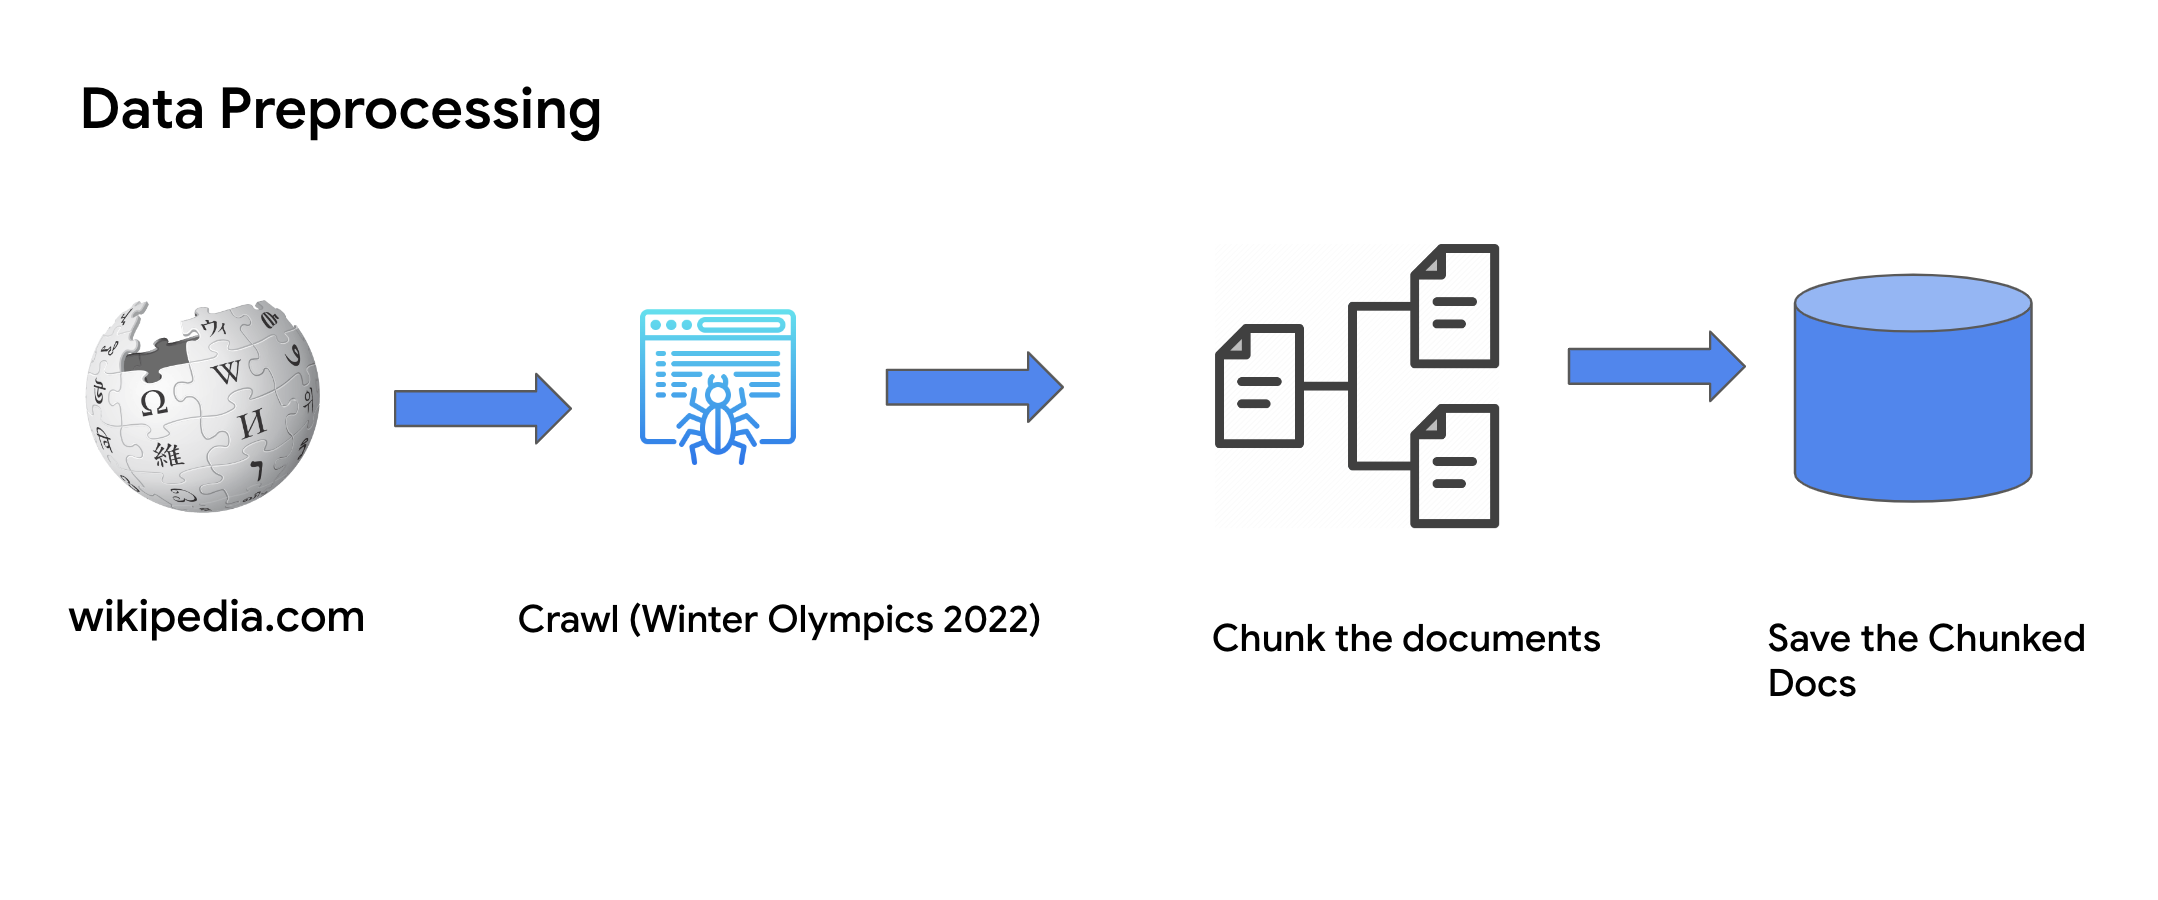



# Authenticate and Install the Libraries

In [ ]:
#Authenticate with your google cloud account
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
# Install all the needed packages

#Midiawiki client
!pip install mwclient

#MidiaWiki parser
!pip install mwparserfromhell


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.9 MB/s eta 0:00:00


# Import the libraries and Set Categories to Extract

In [ ]:
# Import the needed libraries for this module

# Import packages
import re
import pandas as pd
import mwclient
import mwparserfromhell


Note: If you change the the topice from Winter Olympocs to something else. Do not forget to add **"Category:"** before the category title.


In [ ]:
# get Wikipedia pages about the 2022 Winter Olympics

#CATEGORY_TITLE = "Category:2022 Winter Olympics"#@param
CATEGORY_TITLE = "Category:2022 FIFA World Cup"#@param


WIKI_SITE = "en.wikipedia.org"
CSV_FILE = "wikipedia_strings.csv" #@param

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Extractor

In [ ]:


def titles_from_category(
    category: mwclient.listing.Category, max_depth: int
) -> set[str]:
    """Return a set of page titles in a given Wiki category and its subcategories."""
    titles = set()
    for cm in category.members():
        if type(cm) == mwclient.page.Page:
            # ^type() used instead of isinstance() to catch match w/ no inheritance
            titles.add(cm.name)
        elif isinstance(cm, mwclient.listing.Category) and max_depth > 0:
            deeper_titles = titles_from_category(cm, max_depth=max_depth - 1)
            titles.update(deeper_titles)
    return titles


site = mwclient.Site(WIKI_SITE)
category_page = site.pages[CATEGORY_TITLE]
titles = titles_from_category(category_page, max_depth=1)
# ^note: max_depth=1 means we go one level deep in the category tree
print(f"Found {len(titles)} article titles in {CATEGORY_TITLE}.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Found 962 article titles in Category:2022 FIFA World Cup.


# Data Cleanup
Now that we have our reference documents, we need to prepare them for search.


Discard less relevant-looking sections like External Links and Footnotes
Clean up the text by removing reference tags (e.g., ), whitespace, and super short sections
Split each article into sections
Prepend titles and subtitles to each section's text, to help PaLM understand the context
If a section is long (say, > 1,600 tokens), we'll recursively split it into smaller sections, trying to split along semantic boundaries like paragraphs

In [ ]:
SECTIONS_TO_IGNORE = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]


def all_subsections_from_section(
    section: mwparserfromhell.wikicode.Wikicode,
    parent_titles: list[str],
    sections_to_ignore: set[str],
) -> list[tuple[list[str], str]]:
    """
    From a Wikipedia section, return a flattened list of all nested subsections.
    Each subsection is a tuple, where:
        - the first element is a list of parent subtitles, starting with the page title
        - the second element is the text of the subsection (but not any children)
    """
    headings = [str(h) for h in section.filter_headings()]
    title = headings[0]
    if title.strip("=" + " ") in sections_to_ignore:
        # ^wiki headings are wrapped like "== Heading =="
        return []
    titles = parent_titles + [title]
    full_text = str(section)
    section_text = full_text.split(title)[1]
    if len(headings) == 1:
        return [(titles, section_text)]
    else:
        first_subtitle = headings[1]
        section_text = section_text.split(first_subtitle)[0]
        results = [(titles, section_text)]
        for subsection in section.get_sections(levels=[len(titles) + 1]):
            results.extend(all_subsections_from_section(subsection, titles, sections_to_ignore))
        return results


def all_subsections_from_title(
    title: str,
    sections_to_ignore: set[str] = SECTIONS_TO_IGNORE,
    site_name: str = WIKI_SITE,
) -> list[tuple[list[str], str]]:
    """From a Wikipedia page title, return a flattened list of all nested subsections.
    Each subsection is a tuple, where:
        - the first element is a list of parent subtitles, starting with the page title
        - the second element is the text of the subsection (but not any children)
    """
    site = mwclient.Site(site_name)
    page = site.pages[title]
    text = page.text()
    parsed_text = mwparserfromhell.parse(text)
    headings = [str(h) for h in parsed_text.filter_headings()]
    if headings:
        summary_text = str(parsed_text).split(headings[0])[0]
    else:
        summary_text = str(parsed_text)
    results = [([title], summary_text)]
    for subsection in parsed_text.get_sections(levels=[2]):
        results.extend(all_subsections_from_section(subsection, [title], sections_to_ignore))
    return results

# split pages into sections
# may take ~1 minute per 100 articles
wikipedia_sections = []
for title in titles:
    wikipedia_sections.extend(all_subsections_from_title(title))
print(f"Found {len(wikipedia_sections)} sections in {len(titles)} pages.")




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Found 11468 sections in 962 pages.


In [ ]:
# This is for English Language. Change this for other languagse
tokens_to_char = 4 #@param

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

MAX_INPUT_TOKEN = 4095 # One less than Max for PaLM API of 4096


def num_tokens(text: str) -> int:
    """Return the number of tokens in a string."""
    strlength =  len(text)
    tokens = int(strlength/4)
    return tokens


def halved_by_delimiter(string: str, delimiter: str = "\n") -> list[str, str]:
    """Split a string in two, on a delimiter, trying to balance tokens on each side."""
    chunks = string.split(delimiter)
    if len(chunks) == 1:
        return [string, ""]  # no delimiter found
    elif len(chunks) == 2:
        return chunks  # no need to search for halfway point
    else:
        total_tokens = num_tokens(string)
        halfway = total_tokens // 2
        best_diff = halfway
        for i, chunk in enumerate(chunks):
            left = delimiter.join(chunks[: i + 1])
            left_tokens = num_tokens(left)
            diff = abs(halfway - left_tokens)
            if diff >= best_diff:
                break
            else:
                best_diff = diff
        left = delimiter.join(chunks[:i])
        right = delimiter.join(chunks[i:])
        return [left, right]


def truncated_string(
    string: str,
    max_tokens: int,
    print_warning: bool = True,
) -> str:
    """Truncate a string to a maximum number of tokens."""
    truncated_string = string[:MAX_INPUT_TOKEN]
    if print_warning and len(string) > MAX_INPUT_TOKEN:
        print(f"Warning: Truncated string from {len(string)} tokens to {MAX_INPUT_TOKEN} tokens.")
    return truncated_string


def split_strings_from_subsection(
    subsection: tuple[list[str], str],
    max_tokens: int = 4095,
    max_recursion: int = 5,
) -> list[str]:
    """
    Split a subsection into a list of subsections, each with no more than max_tokens.
    Each subsection is a tuple of parent titles [H1, H2, ...] and text (str).
    """
    titles, text = subsection
    string = "\n\n".join(titles + [text])
    num_tokens_in_string = num_tokens(string)
    # if length is fine, return string
    if num_tokens_in_string <= MAX_INPUT_TOKEN:
        return [string]
    # if recursion hasn't found a split after X iterations, just truncate
    elif max_recursion == 0:
        return [truncated_string(string, max_tokens=MAX_INPUT_TOKEN)]
    # otherwise, split in half and recurse
    else:
        titles, text = subsection
        for delimiter in ["\n\n", "\n", ". "]:
            left, right = halved_by_delimiter(text, delimiter=delimiter)
            if left == "" or right == "":
                # if either half is empty, retry with a more fine-grained delimiter
                continue
            else:
                # recurse on each half
                results = []
                for half in [left, right]:
                    half_subsection = (titles, half)
                    half_strings = split_strings_from_subsection(
                        half_subsection,
                        max_tokens=max_tokens,
                        max_recursion=max_recursion - 1,
                    )
                    results.extend(half_strings)
                return results
    # otherwise no split was found, so just truncate (should be very rare)
    return [truncated_string(string, max_tokens=max_tokens)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Chunk the Documents

In [ ]:
# split sections into chunks. This will take some time to run
MAX_TOKENS = 1600
wikipedia_strings = []
for section in wikipedia_sections:
    wikipedia_strings.extend(split_strings_from_subsection(section, max_tokens=MAX_TOKENS))

print(f"{len(wikipedia_sections)} Wikipedia sections split into {len(wikipedia_strings)} strings.")


11468 Wikipedia sections split into 11561 strings.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Validate to see the max Size of the chuncks
len_str = []
for wik in wikipedia_strings:
 len_str.append(len(wik))

len_str.sort(reverse=True)
len_str[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[16379, 16353, 16340, 16231, 16212]

# Save the Chunked Text to local file

In [ ]:
#Save the Chunked documents in a Dataframe to persist to storage
import pandas as pd
df = pd.DataFrame()
df["text"] = wikipedia_strings
df.to_csv(CSV_FILE)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Save a Copy in GCS

Please read the [bucket](https://cloud.google.com/storage/docs/buckets#:~:text=Your%20bucket%20names%20must%20meet,Names%20containing%20dots%20require%20verification) naming conventions. You cannot use uppercase letters.

In [ ]:

PROJECT_ID = "demogct2022" #@param
BUCKET_TO_SAVE= f"fifa_wikipedia_strings_{PROJECT_ID}"#@param
REGION ="us-central1"#@param

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import os
from google.cloud import storage

# Create a storage client
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET_TO_SAVE)
bucket.location = REGION

try:
  bucket = client.get_bucket(BUCKET_TO_SAVE)
  print(f"Bucket {BUCKET_TO_SAVE} exists.")
except:
  print(f"Creating bucket {BUCKET_TO_SAVE}")
  bucket.create()
  print(f"Bucket {BUCKET_TO_SAVE} created.")


# Check if the wikipedia_strings.csv file exists locally
if os.path.exists(CSV_FILE):
  # Copy the file
  #client.copy_file('wikipedia_strings.csv', f'gs://{BUCKET_TO_SAVE}/wikipedia_strings.csv')
  blob = bucket.blob(CSV_FILE)
  blob.upload_from_filename(CSV_FILE)
  print(f"Blob {BUCKET_TO_SAVE}/{CSV_FILE} uploaded to {BUCKET_TO_SAVE}.")
else:
  print(f"The {CSV_FILE} file does not exist.")
  print ("Please save the dataframe in the above frames")

stats = storage.Blob(bucket=bucket, name=CSV_FILE).exists(client)
if stats:
  print(f"Blob gs://{BUCKET_TO_SAVE}/{CSV_FILE} exists.")
else:
  print(f"Blob gs://{BUCKET_TO_SAVE}/{CSV_FILE} does not exist.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-33-29d4ac363502>:7: DeprecationWarning: Assignment to 'Bucket.location' is deprecated, as it is only valid before the bucket is created. Instead, pass the location to `Bucket.create`.
  bucket.location = REGION


Bucket fifa_wikipedia_strings_demogct2022 exists.
Blob fifa_wikipedia_strings_demogct2022/wikipedia_strings.csv uploaded to fifa_wikipedia_strings_demogct2022.
Blob gs://fifa_wikipedia_strings_demogct2022/wikipedia_strings.csv exists.


# Completed

Now you have completed crawling and creating the data.
In the next section we will load this data into [Embedding Generation](https://colab.sandbox.google.com/drive/18PIFU1o7wzW_o-_pLyElhtAy60sD1xoj?resourcekey=0-F_vg-Q6i3uTL0B0WtsHCjg).